In [1]:
import sys
sys.path.insert(0, '..')
from visualization import test_subgroup_separation, plot_k_series_with_shaps

In [2]:
import copy
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import ShuffleSplit

In [3]:
df = pd.read_csv('../data/sin_synth/SIN_RANDY_NONOISE_500.csv')

In [4]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,error,label
0,176.107856,-38.292281,-83.633367,-130.510875,45.917780,-198.701307,27.789212,-14.355077,32.489286,38.293906,...,8.267257,115.987310,-16.361367,-16.296124,-0.519341,57.189860,-62.385178,163.477655,0.593159,0.0
1,100.961410,114.652989,16.501596,122.400534,269.075282,-11.194462,137.764530,-120.118107,-106.206571,236.171774,...,1.452680,-64.936704,-53.720485,10.504204,-19.586896,50.286487,-69.378273,127.678153,0.460127,0.0
2,-34.271320,48.175821,107.899320,-52.795608,30.277780,-41.432483,34.452543,6.573040,-63.255035,14.422148,...,-47.087189,110.905690,-39.843555,-41.198753,25.415166,23.234761,158.668992,-177.656889,0.377501,0.0


In [5]:
df.error.describe()

count    500.000000
mean       0.700083
std        0.210911
min        0.200191
25%        0.500853
50%        0.767173
75%        0.898267
max        0.996475
Name: error, dtype: float64

In [6]:
df.label.value_counts()

1.0    250
0.0    250
Name: label, dtype: int64

In [7]:
len(df)

500

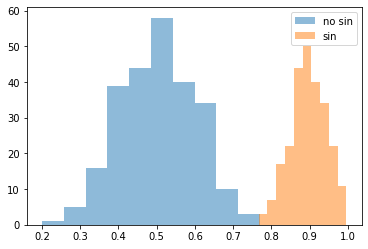

In [8]:
# Plot error distributions
plt.hist(df.loc[df['label']==0, 'error'], alpha=0.5, label='no sin')
plt.hist(df.loc[df['label']==1, 'error'], alpha=0.5, label='sin')
plt.legend(loc='upper right')

In [9]:
X = df.drop(columns=['error', 'label']) #'sin_x0', 'sin_x1', 'sin_y'
y = df['error']

In [10]:
sss = ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
sss.get_n_splits(X, y)
train_index, test_index = next(sss.split(X, y))

X_train, y_train = X.iloc[train_index], y.iloc[train_index]
X_test, y_test = X.iloc[test_index], y.iloc[test_index]

In [11]:
import gendis
from gendis.genetic import GeneticExtractor
from gendis.subgroup_distance import SubgroupDistance

/home/samir/miniconda3/envs/gendis/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [29]:
DIST_THRESHOLD = 30

fitness_func = SubgroupDistance(
    distance_function=SubgroupDistance.wasserstein_distance, 
    shapelet_dist_threshold=DIST_THRESHOLD,
    min_support=10,
    standardize=False
)

args = {
    "dist_function": "dtw",
    "apply_differencing": True,
    "fitness": fitness_func,
    "population_size": 100, 
    "iterations": 50,  
    "mutation_prob": 0.5, 
    "crossover_prob": 0.5,
    "max_shaps": 3,
    "wait": 10, 
    "min_len": 30,
    "max_len": 60,
    "n_jobs": multiprocessing.cpu_count() - 3,
    "verbose": True,
    "dist_threshold": DIST_THRESHOLD,
} 

gendis = GeneticExtractor(**args)

In [30]:
gendis.__dict__

{'dist_function': <function gendis.shapelets_distances.dtw(timeseries_matrix, shaps, distances)>,
 'dist_func_returns': True,
 'fitness': <gendis.subgroup_distance.SubgroupDistance at 0x71a31bc42b00>,
 'apply_differencing': True,
 'population_size': 100,
 'iterations': 50,
 'verbose': True,
 'mutation_prob': 0.5,
 'crossover_prob': 0.5,
 'plot': None,
 'wait': 10,
 'n_jobs': 13,
 'normed': False,
 'min_len': 30,
 'max_len': 60,
 'max_shaps': 3,
 'init_ops': [<function gendis.operators.random_shapelet(X, n_shapelets, min_len_series, max_len, min_len=4)>,
  <function gendis.operators.kmeans(X, n_shapelets, min_len_series, max_len, n_draw=None, min_len=4)>],
 'cx_ops': [<function gendis.operators.merge_crossover(ind1, ind2, p=0.25)>,
  <function gendis.operators.point_crossover(ind1, ind2)>,
  <function gendis.operators.shap_point_crossover(ind1, ind2, p=0.25)>],
 'mut_ops': [<function gendis.operators.add_shapelet(shapelets, toolbox)>,
  <function gendis.operators.remove_shapelet(shapele

In [31]:
%%time
gendis.fit(X_train, y_train)

it		avg		std		max		time
1		--		--		--	1.5242
2		--		--		--	1.3073
3		0.192		0.009		0.198896	1.4314
4		0.1749		0.015		0.198896	1.5673
5		0.1696		0.036		0.198896	1.4226
6		0.1809		0.007		0.198896	1.2321
7		0.1766		0.027		0.198896	1.0485
8		0.1791		0.019		0.198896	0.9681
9		0.1815		0.017		0.198896	0.894
10		0.1845		0.005		0.198896	1.0839
11		0.1837		0.003		0.198896	0.9987
12		0.1833		0.016		0.198896	1.0413
CPU times: user 23.7 s, sys: 244 ms, total: 23.9 s
Wall time: 31.5 s


In [33]:
gendis.best

{'it': 3,
 'score': 0.1988955399017685,
 'info': {'dist': 0.1988955399017685,
  'coverage_weight': 1,
  'subgroup_error_mean': 0.8970946198399007,
  'population_mean': 0.6981990799381322,
  'subgroup_size': 125},
 'shapelets': [array([  6.04163812,   0.6982959 ,  -4.77412573,  -9.36405423,
         -12.22304516])]}

In [34]:
%%time
distances = gendis.transform(X_test, standardize=False, return_positions=True)

CPU times: user 59.3 ms, sys: 162 µs, total: 59.5 ms
Wall time: 54.8 ms


Testing separation for shapelet 0


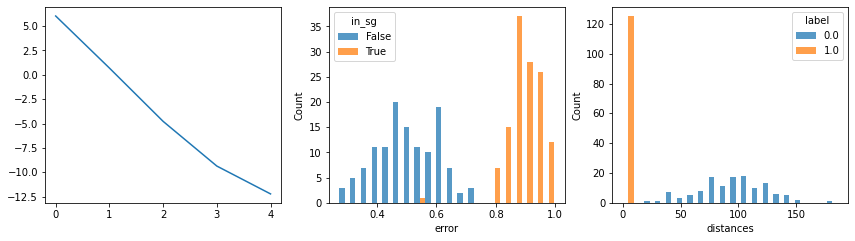

Subgroup 'accuracy': 0.996
confusion matrix, label x subgroup label
[[124   1]
 [  0 125]]
Error stats
Samples in subgroup:
count    126.000000
mean       0.892885
std        0.056531
min        0.553215
25%        0.865171
50%        0.894319
75%        0.930727
max        0.996475
Name: error, dtype: float64

Samples not in subgroup:
count    124.000000
mean       0.507969
std        0.102236
min        0.273081
25%        0.435832
50%        0.495051
75%        0.598094
max        0.735110
Name: error, dtype: float64


In [35]:
for i, shap in enumerate(gendis.best['shapelets'], start=0):
    print(f"Testing separation for shapelet {i}")
    _X_test = copy.deepcopy(X_test)
    _y_test = copy.deepcopy(y_test)
    
    subgroups = gendis.get_subgroups(_X_test, _y_test, shapelets=[shap])
    
    _X_test['distances'] = distances[f'D_{i}']
    _X_test['positions'] = distances[f'L_{i}']
     
    test_subgroup_separation(
        df=df, 
        X=_X_test, 
        y=_y_test, 
        subgroups=subgroups, 
        shap=shap
    )

In [36]:
_X_test = _X_test.sort_values(by='distances')

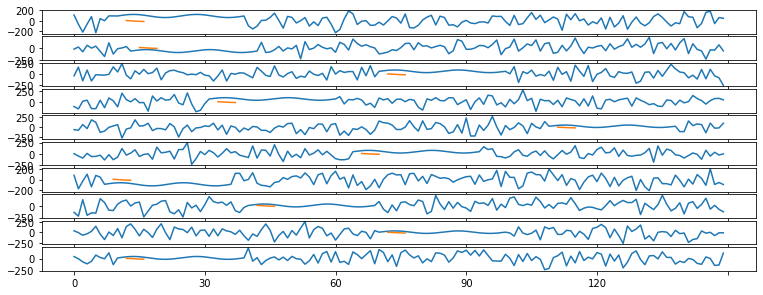

In [37]:
plot_k_series_with_shaps(
    _X_test, k=10, 
    shap=gendis.best['shapelets'][0], 
    X_ordered=True
)